Use AutoDiffPulse to design a box-ROI OV suppression pulse

In [7]:
import torch
import numpy as np
import os
import math

In [8]:
import sys
sys.path.append('/home/yonglihe/jon_scan/adpulses_ss')
sys.path.append('/home/yonglihe/github/HolisticMRI//mrphy_ss')

import optimizers_ss
import mobjs
from mobjs import SpinCube, Pulse
import metrics
import penalties
from mrphy import dt0, gmax0, smax0, rfmax0

In [9]:
sys.path.append('/home/yonglihe/github/my_utils')
from vis import SACshow, pulse2np, plot_seq, g2k

In [4]:
device0=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device0

device(type='cuda', index=0)

In [5]:
# data_root='/scratch/jfnielse_root/jfnielse0/yonglihe/calgary_t1w_sim/train/'
# sub_npz=np.load(os.path.join(data_root,'sub001.npz'))

# t1map=torch.tensor(sub_npz['t1map'],device=device0).unsqueeze(0)*1e-3
# t2map=torch.tensor(sub_npz['t2map'],device=device0).unsqueeze(0)*1e-3
# pdmap=torch.tensor(sub_npz['pdmap'],device=device0).unsqueeze(0)*1e-3

tissue_map=np.load('./jonhead_tissuemap.npz')
t1map=tissue_map['t1map']
t2map=tissue_map['t2map']
pdmap=tissue_map['pdmap']

t1map_tc=torch.tensor(t1map,device=device0).unsqueeze(0)
t2map_tc=torch.tensor(t2map,device=device0).unsqueeze(0)
pdmap_tc=torch.tensor(pdmap,device=device0).unsqueeze(0)


M0=torch.zeros(pdmap_tc.shape+(3,),device=device0)
M0[...,2]=pdmap_tc

fov=torch.tensor([[24,24,24]],device=device0)

#phantom=SpinCube(t1map.shape,fov,T1=t1map,T2=t2map,M=M0,device=device0)


In [6]:
def Target_SS(cube, iv, ov, beta_iv=60, beta_ov=0, weight_iv=1.0, weight_ov=1.0,alpha=15, T_r=55e-3,device='cpu'):
    """target pattern for iv-saturation Steady state imaging
    inputs:
        - ```T_r```: remaining time from right after beta to end of cycle=TR-dur.(beta)
    """
    nx,ny,nz=iv.shape
    d=torch.zeros(1,nx,ny,nz,3,device=device)
    M0=cube.M[...,2] #(N,*nM)
    
    beta=torch.zeros_like(d[...,2]) #(N,*nM)
    beta[0,...]=beta_iv*iv+beta_ov*ov
    
    E1=torch.exp(-T_r/cube.T1) #(N,*nM)
    

    d[...,2]= (M0*(1-E1))/(1-torch.cos(torch.deg2rad(beta))*math.cos(math.radians(alpha))*E1)
    
    weight=weight_iv*ov+weight_ov*iv
    weight=weight[None,...]

    target={
        "d":d,
        "weight":weight
        }

    return target

In [7]:
iv=torch.zeros_like(t1map_tc) #[1,*nM]
nx,ny,nz=t1map_tc.shape[1:]
iv[0,nx//2-nx//4+5:nx//2+nx//4-5,ny//2-ny//4+5:ny//2+ny//4-5,nz//2-nz//4+5:nz//2+nz//4-5]=1

iv_ext=torch.zeros_like(t1map_tc) #[1,*nM]
iv_ext[0,nx//2-nx//4+3:nx//2+nx//4-3,ny//2-ny//4+3:ny//2+ny//4-3,nz//2-nz//4+3:nz//2+nz//4-3]=1
ov=1-iv_ext

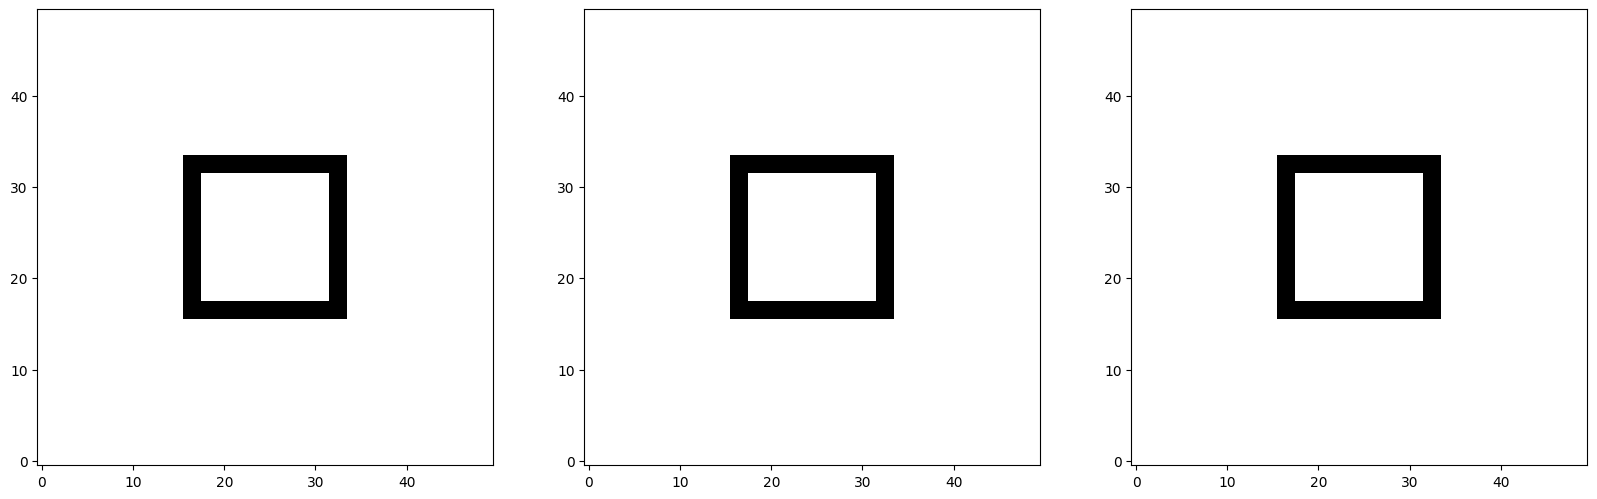

In [8]:
sim_mask=(iv+ov).bool()
SACshow(sim_mask[0,...].cpu().numpy(),pad=False)

In [9]:
phantom=SpinCube(t1map_tc.shape,fov,mask=sim_mask,T1=t1map_tc,T2=t2map_tc,device=device0)

/home/yonglihe/miniconda3/envs/holisticMRI/lib/python3.11/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
pIni_path='../HolisticMRI/InitialPulse/pIni_OV90.npz'
pulse_npz=np.load(pIni_path)
rf=torch.tensor(pulse_npz['rf']).unsqueeze(0).to(device0)
gr=torch.tensor(pulse_npz['gr']).unsqueeze(0).to(device0)

pIni=Pulse(rf=rf,gr=gr,rfmax=rfmax0,gmax=gmax0,smax=torch.tensor(15e3).to(device0),dt=dt0,device=device0)

In [11]:
target_ss=Target_SS(phantom,iv.squeeze(0),ov.squeeze(0),beta_iv=0,beta_ov=85,alpha=20, T_r=55e-3-pIni.dt*pIni.rf.shape[-1],device=device0,weight_iv=0.1,weight_ov=0.9)

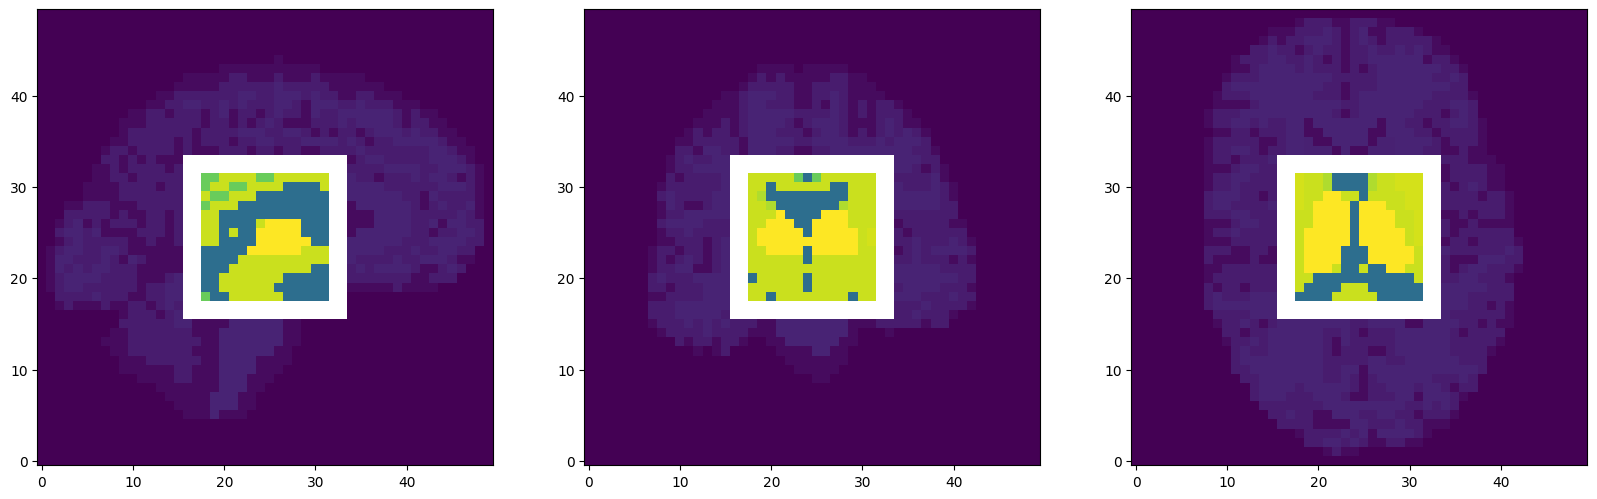

In [12]:
SACshow(target_ss['d'][0,...,2].cpu().numpy(),cmap='viridis')

In [13]:
target_ss['d'][0,25,:,25,2].unique()

tensor([5.3041e-05, 1.3172e-02, 3.5405e-02, 4.6718e-02, 1.6888e-01, 4.2729e-01,
        4.6490e-01,        nan,        nan,        nan,        nan],
       device='cuda:0')

In [14]:
phantom.T1.unique()

tensor([0.9540, 1.0760, 1.1070,  ...,    nan,    nan,    nan], device='cuda:0')

In [15]:
target_ss_={
    'd_':phantom.extract(target_ss['d']),
    'weight_':phantom.extract(target_ss['weight'])
}

In [16]:
#pIni=6ms alpha=20, TR=80ms
[pAD,optInfo]=optimizers_ss.arctanLBFGS(target_ss_,phantom,pIni,sms=False, niter=4,alpha=20, TR=80e-3, fn_err=metrics.err_l2z,fn_pen=penalties.pen_null)

0	 | 0.000	 | 3.245e+02	 | 0.000e+00	 | 3.245e+02	 | 2.662e-03

#iter	 ‖ elapsed time	 ‖ error	 ‖ penalty	 ‖ total loss	 ‖ avg loss
rf-loop:  2
1	 | 48.238	 | 3.191e+01	 | 0.000e+00	 | 3.191e+01	 | 2.618e-04
1	 | 95.397	 | 1.514e+01	 | 0.000e+00	 | 1.514e+01	 | 1.242e-04
gr-loop:  2
1	 | 286.254	 | 1.241e+01	 | 0.000e+00	 | 1.241e+01	 | 1.018e-04
1	 | 480.685	 | 1.077e+01	 | 0.000e+00	 | 1.077e+01	 | 8.831e-05
rf-loop:  2
2	 | 527.999	 | 6.398e+00	 | 0.000e+00	 | 6.398e+00	 | 5.248e-05
2	 | 578.889	 | 4.762e+00	 | 0.000e+00	 | 4.762e+00	 | 3.906e-05
gr-loop:  2
2	 | 771.359	 | 4.408e+00	 | 0.000e+00	 | 4.408e+00	 | 3.615e-05
2	 | 965.629	 | 3.837e+00	 | 0.000e+00	 | 3.837e+00	 | 3.147e-05
rf-loop:  2
3	 | 1012.695	 | 3.076e+00	 | 0.000e+00	 | 3.076e+00	 | 2.523e-05
3	 | 1059.713	 | 2.593e+00	 | 0.000e+00	 | 2.593e+00	 | 2.127e-05
gr-loop:  2
3	 | 1250.511	 | 2.444e+00	 | 0.000e+00	 | 2.444e+00	 | 2.005e-05
3	 | 1358.038	 | 2.412e+00	 | 0.000e+00	 | 2.412e+00	 | 1.978e-05
rf-loop:  2
4	

In [10]:
def saveAD(pAD,optInfo,filename):
    '''save the optimized pulse and loss history
    '''
    data={
        'rf':pAD.rf.cpu().numpy(),
        'gr':pAD.gr.cpu().numpy(),
        'time':optInfo['time_hist'],
        'loss':optInfo['loss_hist']
        #'optInfo':optInfo
    }
    ext=os.path.splitext(filename)[1]
    print(ext)
    if ext=='.h5':
        with h5py.File(filename,'w') as file:
            for key,value in data.items():
                file.create_dataset(key,data=value)
    elif ext=='.mat':
        scipy.io.savemat(filename,data)
    elif ext=='.npz':
        np.savez(filename,rf=data['rf'],gr=data['gr'],time=data['time'],loss=data['loss'])
    return

In [12]:
import scipy
adnpz=np.load('./pIni-from-ROITrained.npz')
rf=adnpz['rf']
gr=adnpz['gr']
scipy.io.savemat('pIni-from-ROITrained.mat',{'rf':rf,'gr':gr})

In [18]:
saveAD(pAD,optInfo,'pAD-EXT-guide-jonhead-TR80ms.npz')

.npz


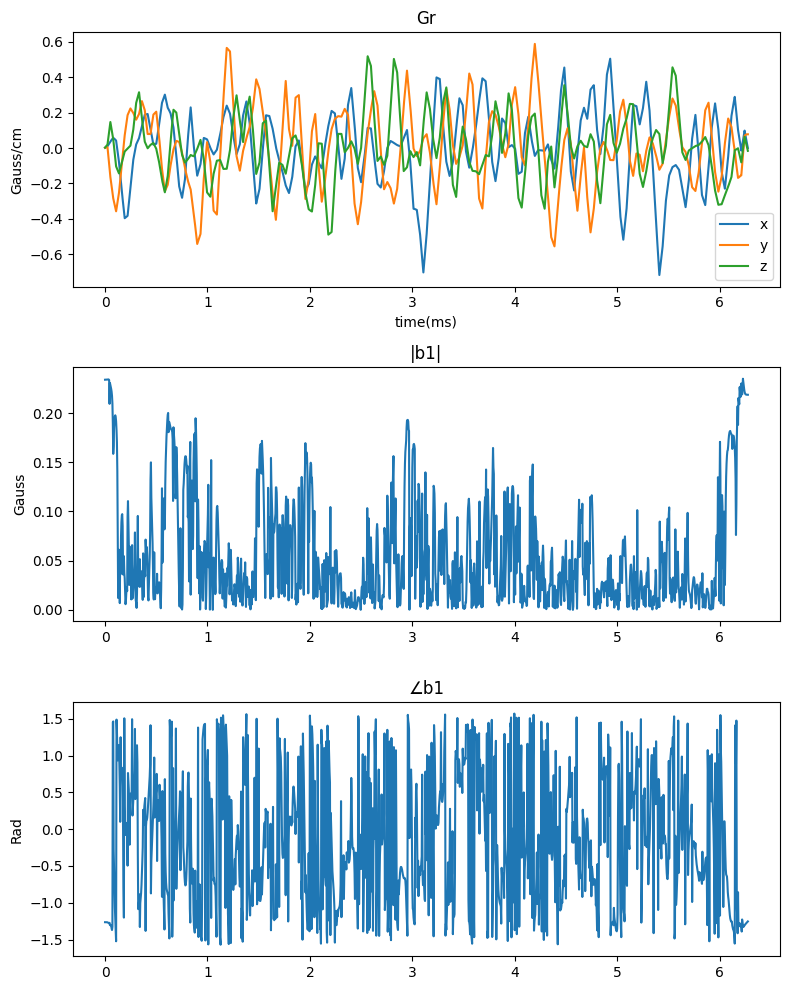

In [20]:
#[gx,gy,gz,rf_mag,rf_phase]=pulse2np(pAD)
plot_seq(pAD)

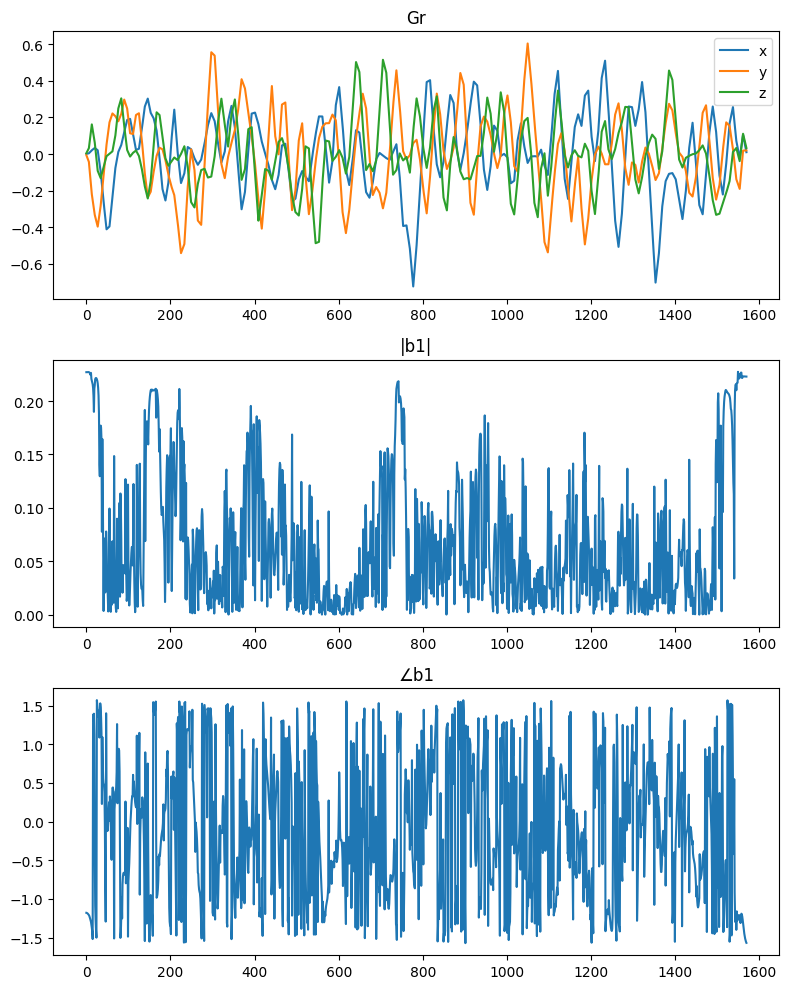

In [28]:
[gx2,gy2,gz2,rf_mag2,rf_phase2]=pulse2np(pIni)
plot_seq(gx2,gy2,gz2,rf_mag2,rf_phase2)

In [29]:
# pAD_npz=np.load('./pAD-EXT-guide-sub001.npz')
# rf_opt=pAD_npz

In [21]:
Mss=phantom.applypulse_ss(pAD,doEmbed=True,alpha=20,TR=80e-3)
#Mss_ini=phantom.applypulse_ss(pIni,doEmbed=True,alpha=20)

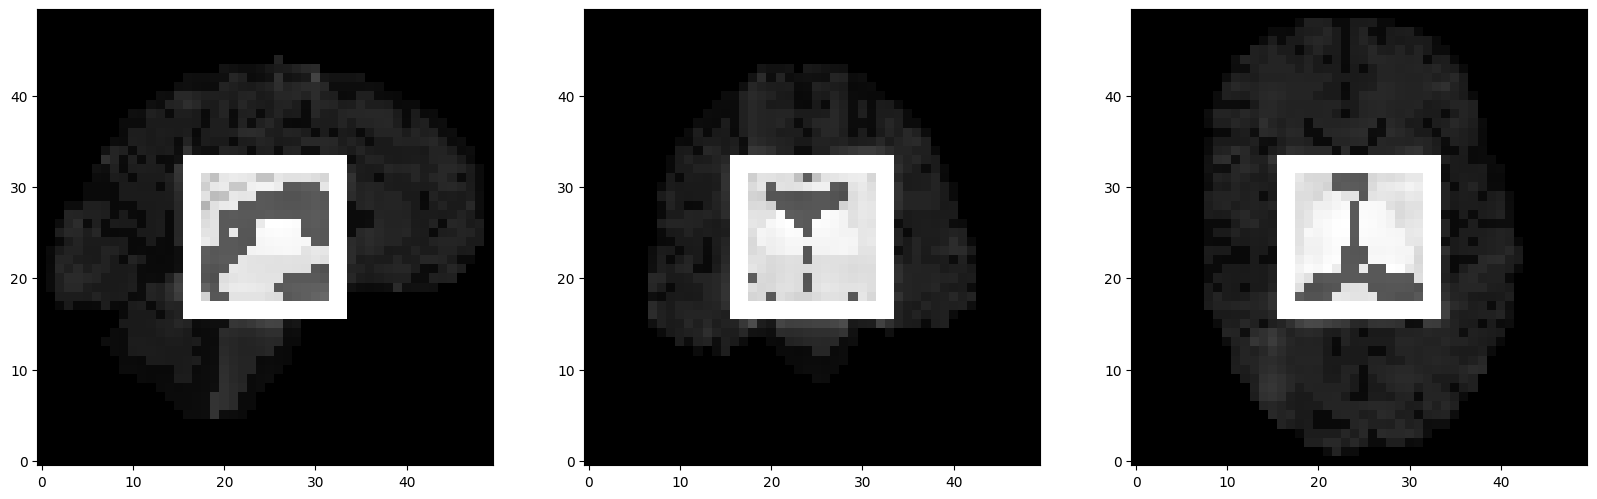

In [22]:
SACshow(Mss[0,...,2].cpu().numpy())

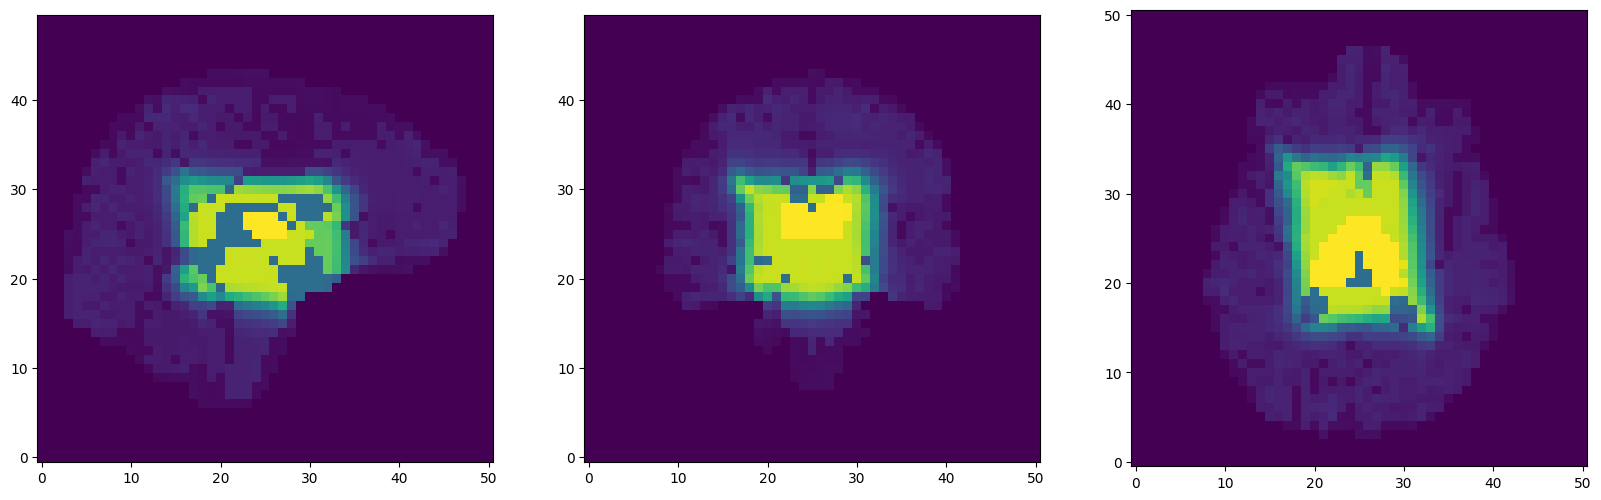

In [33]:
SACshow(Mss_ini[0,...,2].cpu().numpy(),cmap='viridis')